Книга для обучения GCAEC классификатора с использованием Tensorflow из статьи https://gitlab.com/protsenkovi/efd_nn/

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import random
import tensorflow as tf
# tf.autograph.set_verbosity(1)
# tf.get_logger().setLevel('INFO')
import tensorflow_addons as tfa
from IPython.display import display, clear_output
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Reshape, SimpleRNN, GRU, LSTM, PReLU, MaxPooling1D, Flatten, AveragePooling1D, \
    GaussianNoise
from tensorflow.keras.layers import Conv1D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras import losses 
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.saving import load_model
from tensorflow.keras.utils import plot_model
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from time import time

np.random.seed(42)
random.seed(42)
clear_output()

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
print(tf.__version__)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs
2.12.0


In [2]:
window = 24

X_train = np.load(f"../assets/X_train_{window}.npy")
y_train = np.load(f"../assets/y_train_{window}.npy")
X_val = np.load(f"../assets/X_val_{window}.npy")
y_val = np.load(f"../assets/y_val_{window}.npy")
X_test = np.load(f"../assets/X_test_{window}.npy")
y_test = np.load(f"../assets/y_test_{window}.npy")

shuffled_index = np.arange(X_train.shape[0])
np.random.shuffle(shuffled_index)
X_train = X_train[shuffled_index]
y_train = y_train[shuffled_index]

shuffled_index = np.arange(X_val.shape[0])
np.random.shuffle(shuffled_index)
X_val = X_val[shuffled_index]
y_val = y_val[shuffled_index]

shuffled_index = np.arange(X_test.shape[0])
np.random.shuffle(shuffled_index)
X_test = X_test[shuffled_index]
y_test = y_test[shuffled_index]

X_train.shape, X_val.shape, X_test.shape

((116600, 24, 6), (29150, 24, 6), (11054, 24, 6))

In [3]:
import tensorflow.keras.layers as kl
import tensorflow.keras as k

def new_pred(predict):
    pred = []
    for i in predict:
        if i < 0.5:
            pred.append(0)
        else:
            pred.append(1)
    return pred

conv_num = -1
def conv_block_name():
    global conv_num
    conv_num = conv_num + 1
    return 'cb_{}'.format(conv_num)

def conv_block(output_timesteps, output_channels, kernel_size, name, activity_regu=None):
    def f(preceding_layer):
        input_timesteps, input_channels = preceding_layer.get_shape().as_list()[1:]
        
        inputs = k.Input(shape=(input_timesteps, input_channels))
               
        act = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='linear', padding='same', name=name+'_conv_features1', activity_regularizer=activity_regu)(inputs)
        gate = kl.Conv1D(output_channels, kernel_size=kernel_size, activation='sigmoid', padding='same', name=name+'_conv_memory')(inputs)
        gated_act = kl.Multiply()([tfa.layers.InstanceNormalization()(kl.PReLU()(act)), gate]) 
               
        a = kl.Permute((2,1))(gated_act)
        b = kl.Dense(output_timesteps, use_bias=False)(a)
        c = kl.Permute((2,1))(b)
        
        m = k.Model(inputs=inputs, outputs=c, name=name)
#         m.summary()
        return m(preceding_layer)
    return f

def model_1D(input_shape):
    inputs = k.Input(shape=input_shape)
    e = conv_block(output_timesteps=window//2, output_channels=128, kernel_size=3, name=conv_block_name())(inputs)
    e = conv_block(output_timesteps=2, output_channels=128, kernel_size=3, name=conv_block_name(), activity_regu=regularizers.l1(1e-3))(e)
    c = kl.Flatten()(e)
    c = Dense(1, activation='sigmoid', name='sigmoid_layer')(c)
    d = conv_block(output_timesteps=window//2, output_channels=128, kernel_size=3, name=conv_block_name())(e)
    d = conv_block(output_timesteps=input_shape[0], output_channels=input_shape[1], kernel_size=3, name=conv_block_name())(d)
    decoder_output = kl.GaussianNoise(1e-2, name='decoder_output')(d)
    
    classifier_model = k.Model(inputs=inputs, outputs=c, name='classifier')
    model = k.Model(inputs=inputs, outputs=[decoder_output, c], name='autoencoder')
    return model, classifier_model

class ProgressCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        results = pd.DataFrame(data=np.array([v for k,v in logs.items()]).reshape(2,4), 
                               columns=['loss', 'ae_loss', 'classifier_loss', 'accuracy'],
                               index=['train','val'])
        results = results.style.set_caption(f"{epoch}")
        clear_output(wait=True)
        display(results)


def train(X_train, y_train, X_val, y_val, model, epochs=50, lr=1e-2):
    model.compile(loss={
                    'decoder_output':losses.MSE,
                    'sigmoid_layer':losses.BinaryCrossentropy()
                  }, 
                  optimizer=Adam(learning_rate=lr), 
                  metrics={
                     'sigmoid_layer': kmetrics.BinaryAccuracy(),
                  })
    try:
        history = model.fit(X_train, 
                        [X_train, y_train], 
                        epochs=epochs,
                        batch_size=4096, 
                        verbose=0,
                        validation_data=(X_val, (X_val, y_val)),
                        callbacks=[ProgressCallback()])
    except KeyboardInterrupt as e:
        history = []
    return history

In [4]:
gcaec, classifier = model_1D(input_shape=X_train.shape[1:])
gcaec.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 6)]      0           []                               
                                                                                                  
 cb_0 (Functional)              (None, 12, 128)      8480        ['input_1[0][0]']                
                                                                                                  
 cb_1 (Functional)              (None, 2, 128)       100376      ['cb_0[0][0]']                   
                                                                                                  
 cb_2 (Functional)              (None, 12, 128)      99096       ['cb_1[0][0]']                   
                                                                                        

In [5]:
start = time()

history = train(X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, model=gcaec, lr=1e-4, epochs=1000)

print("\nTraining time = ", (time() - start) / 60)


Training time =  11.216969986756643


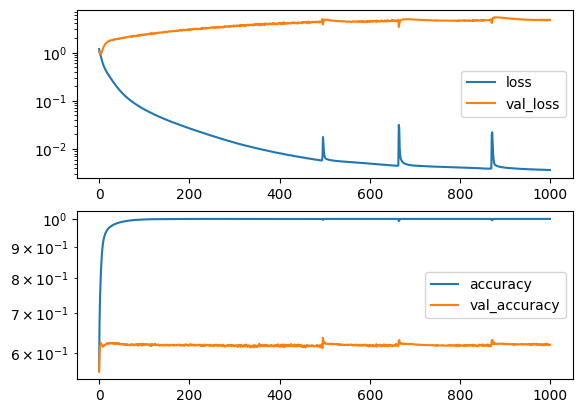

In [6]:
f, [a1,a2] = plt.subplots(2,1)
a1.plot(history.history['loss'], label='loss')
a1.plot(history.history['val_loss'], label='val_loss')
a1.set_yscale('log')
a1.legend()
a2.plot(history.history['sigmoid_layer_binary_accuracy'], label='accuracy')
a2.plot(history.history['val_sigmoid_layer_binary_accuracy'], label='val_accuracy')
a2.set_yscale('log')
a2.legend()

In [7]:
threshold = 0.5

In [8]:
pred_train = classifier.predict(X_train) > threshold
conf_train = confusion_matrix(y_train, pred_train)
acc_train = (conf_train[0][0] + conf_train[1][1]) / (conf_train[0][0] + conf_train[1][1] + conf_train[0][1] + conf_train[1][0])
f1_train = (2 * conf_train[1][1]) / (2 * conf_train[1][1] + conf_train[0][1] + conf_train[1][0])
print('Train Accuracy: ', acc_train)
print('F1: ', f1_train)

3644/3644 [==============================] - 8s 2ms/step
Train Accuracy:  1.0
F1:  1.0


In [9]:
pred_val = classifier.predict(X_val) > threshold
conf_val = confusion_matrix(y_val, pred_val)
acc_val = (conf_val[0][0] + conf_val[1][1]) / (conf_val[0][0] + conf_val[1][1] + conf_val[0][1] + conf_val[1][0])
f1_val = (2 * conf_val[1][1]) / (2 * conf_val[1][1] + conf_val[0][1] + conf_val[1][0])
print('Val Accuracy: ', acc_val)
print('F1: ', f1_val)

911/911 [==============================] - 2s 2ms/step
Val Accuracy:  0.9884734133790738
F1:  0.9885464957731115


In [10]:
predict_cnn = classifier.predict(X_test) > threshold
conf_test = confusion_matrix(y_test, predict_cnn)
acc_test = (conf_test[0][0] + conf_test[1][1]) / (
        conf_test[0][0] + conf_test[1][1] + conf_test[0][1] + conf_test[1][0])
f1_test = (2 * conf_test[1][1]) / (2 * conf_test[1][1] + conf_test[0][1] + conf_test[1][0])
print('Test Accuracy: ', acc_test)
print('F1: ', f1_test)

346/346 [==============================] - 1s 2ms/step
Test Accuracy:  0.6197756468246789
F1:  0.45969919012726573


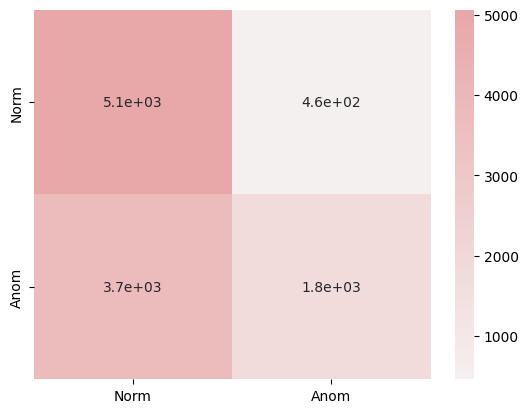

In [11]:
aa = pd.DataFrame(data=conf_test, columns=['Norm', 'Anom'], index=['Norm', 'Anom'])
sns.heatmap(aa, annot=True, cmap=sns.blend_palette(['#f5f0f0','#e8a7a8'], as_cmap=True));

In [12]:
model_file_path = f"../results/gcaec_{window}.h5"
classifier.save(model_file_path, save_format="h5")
pd.DataFrame(
    data=[[model_file_path, acc_train, f1_train, acc_val, f1_val, acc_test, f1_test]], 
    columns=['model', 'acc_train', 'f1_train', 'acc_val', 'f1_val', 'acc_test', 'f1_test']
).to_csv(f"{model_file_path}_stats.csv", index=False)